In [126]:
%%capture --no-stderr
!pip install -U --quiet langgraph langsmith langchain_google_genai

In [127]:
import os
from getpass import getpass


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")


_getpass("GROQ_API_KEY")

GROQ_API_KEY=··········


In [128]:
%pip install --upgrade --quiet  playwright > /dev/null
!playwright install

Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Missing libraries:                                   ║
║     libwoff2dec.so.1.0.2                             ║
║     libgstgl-1.0.so.0                                ║
║     libgstcodecparsers-1.0.so.0                      ║
║     libavif.so.13                                    ║
║     libharfbuzz-icu.so.0                             ║
║     libenchant-2.so.2                                ║
║     libsecret-1.so.0                                 ║
║     libhyphen.so.0                                   ║
║     libmanette-0.2.so.0                              ║
╚══════════════════════════════════════════════════════╝
    at validateDependenciesLinux (/usr/local/lib/python3.11/dist-packages/playwright/driver/package/lib/server/registry/dependencies.js:216:9)
    at async Registry._validateHostRequirements (/usr/local/lib/python3.11/dist

In [129]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

In [130]:
from typing import List, Optional
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

In [141]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

In [142]:
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
# with open("mark_page.js") as f:
#     mark_page_script = f.read()
mark_page_script = """
// Remove async keyword from markPage function
function markPage() {
    // Add your JavaScript code for marking the page
    // Replace the code below with your actual implementation
    const elements = document.querySelectorAll('span, a, p, div, li');
    const bboxes = [];
    elements.forEach((element, index) => {
        const rect = element.getBoundingClientRect();
        bboxes.push({
            x: rect.x,
            y: rect.y,
            width: rect.width,
            height: rect.height,
            text: element.innerText,
            type: element.tagName,
            ariaLabel: element.ariaLabel,
            index: index,
        });
    });
    return bboxes;
}

async function unmarkPage() {
    // Add your JavaScript code for unmarking the page
    // Replace the code below with your actual implementation
    // Example: clear styles added in markPage
    const elements = document.querySelectorAll('span, a, p, div, li');
    elements.forEach((element) => {
        // Reset styles here if applied in markPage
    });
}
"""

@chain_decorator
async def mark_page(page):
    # Define an IIFE (Immediately Invoked Function Expression) that includes both functions
    script = f"""
        (() => {{
            {mark_page_script}
            return markPage();
        }})();
    """

    # Evaluate the script within an IIFE
    bboxes = await page.evaluate(script)

    screenshot = await page.screenshot()

    # Call unmarkPage within the same IIFE
    await page.evaluate(f"(() => {{ {mark_page_script}; return unmarkPage(); }})()")

    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

In [143]:
import asyncio
import base64
from typing import Dict, List, Any

# LangChain imports
from langchain_core.runnables import RunnablePassthrough, chain as chain_decorator
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

# For web interaction (assuming you're using Playwright)
from playwright.async_api import async_playwright

In [159]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model= 'gemini-1.5-flash')

agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

In [160]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

In [161]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, START, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

In [162]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=True, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Type: ['27', 'WebVoyager paper on arxiv']
2. Type: ['27', 'WebVoyager paper on arxiv']
3. Type: ['28', 'WebVoyager paper on arxiv']
4. Type: ['1', 'WebVoyager paper on arxiv']
5. Type: ['28', 'WebVoyager paper on arxiv']
6. Type: ['28', 'WebVoyager paper on arxiv']
7. Type: ['27', 'WebVoyager paper on arxiv']
8. Type: ['1', 'WebVoyager paper arxiv']
9. Type: ['27', 'WebVoyager paper on arxiv']
10. Type: ['27', 'WebVoyager paper on arxiv']
11. Type: ['27', 'WebVoyager paper on arxiv']
12. Type: ['1', 'WebVoyager paper arxiv']
13. Type: ['28', 'WebVoyager paper on arxiv']
14. Type: ['1', 'WebVoyager paper on arxiv']


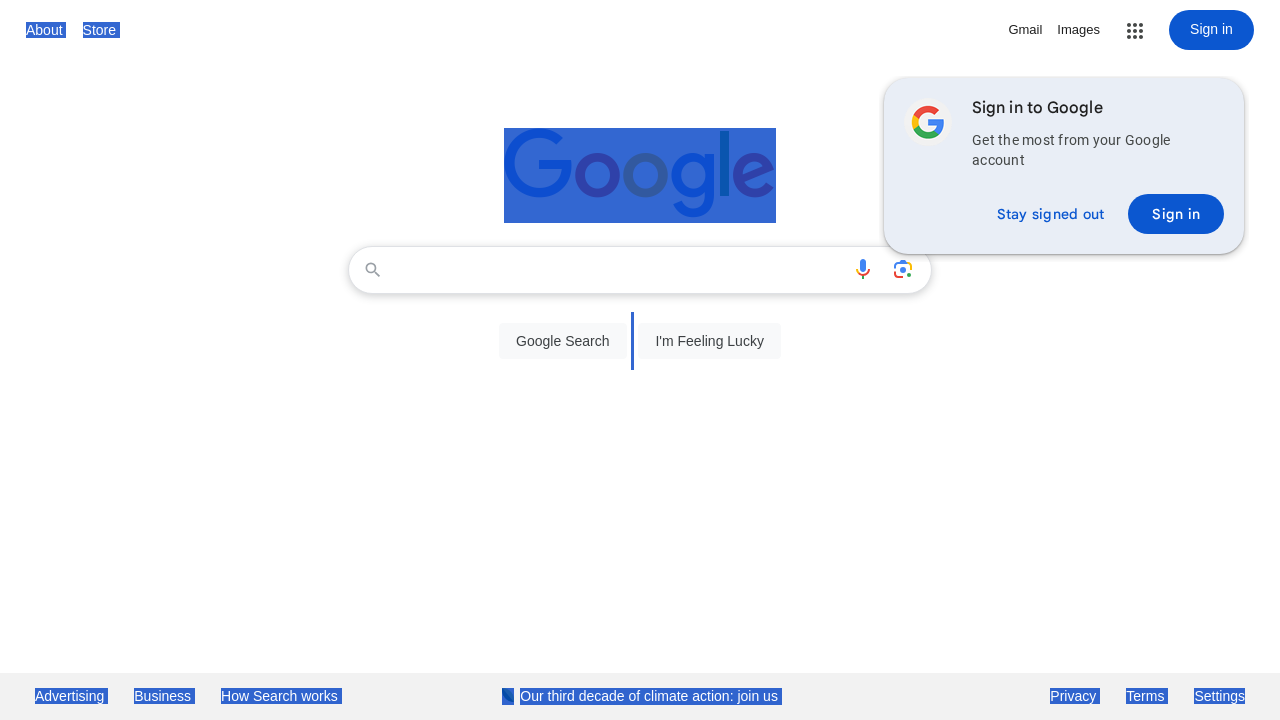

CancelledError: 

In [163]:
res = await call_agent("Could you explain the WebVoyager paper (on arxiv)?", page)
print(f"Final response: {res}")